In [131]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import tensorflow as tf
import tensorflow_io as tfio
print(tfio)
from itertools import groupby
import csv

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten


<module 'tensorflow_io' from 'c:\\Users\\AISHWARYA\\Desktop\\Audio-Classifier\\.conda\\Lib\\site-packages\\tensorflow_io\\__init__.py'>


In [132]:
CAPUCHIN_FILE = os.path.join('data', 'Parsed_Capuchinbird_Clips', 'XC3776-3.wav')
NOT_CAPUCHIN_FILE = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips', 'afternoon-birds-song-in-forest-0.wav')
print(CAPUCHIN_FILE)
print(NOT_CAPUCHIN_FILE)

data\Parsed_Capuchinbird_Clips\XC3776-3.wav
data\Parsed_Not_Capuchinbird_Clips\afternoon-birds-song-in-forest-0.wav


In [133]:
def load_wav_16k_mono(filename):
    # Load the audio file
    y, sr = librosa.load(filename, sr=16000, mono=True)

    # Ensure the audio is in mono
    if len(y.shape) > 1:
        y = librosa.to_mono(y)

    return y

In [134]:
wave = load_wav_16k_mono(CAPUCHIN_FILE)
nwave = load_wav_16k_mono(NOT_CAPUCHIN_FILE)

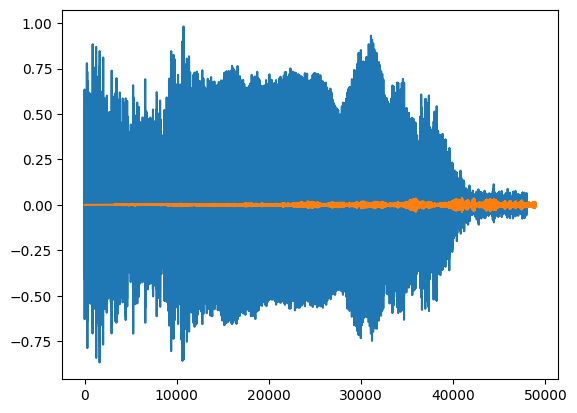

In [135]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

In [136]:
POS = os.path.join('data', 'Parsed_Capuchinbird_Clips')
NEG = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips')

In [137]:
pos = tf.data.Dataset.list_files(POS+'\*.wav')
neg = tf.data.Dataset.list_files(NEG+'\*.wav')

In [138]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

In [139]:
lengths = []
for file in os.listdir(os.path.join('data', 'Parsed_Capuchinbird_Clips')):
    tensor_wave = load_wav_16k_mono(os.path.join('data', 'Parsed_Capuchinbird_Clips', file))
    lengths.append(len(tensor_wave))
lengths

[40000,
 48000,
 56000,
 48000,
 56000,
 64000,
 64000,
 64000,
 56000,
 56000,
 48000,
 56000,
 64000,
 56000,
 40000,
 64000,
 64000,
 64000,
 64000,
 56000,
 56000,
 56000,
 56000,
 48000,
 48000,
 56000,
 56000,
 64000,
 64000,
 48000,
 56000,
 64000,
 56000,
 64000,
 32000,
 40000,
 48000,
 40000,
 56000,
 56000,
 56000,
 56000,
 48000,
 48000,
 64000,
 64000,
 48000,
 64000,
 48000,
 48000,
 40000,
 48000,
 48000,
 56000,
 56000,
 48000,
 40000,
 56000,
 48000,
 40000,
 56000,
 48000,
 48000,
 56000,
 48000,
 64000,
 64000,
 40000,
 40000,
 72000,
 56000,
 56000,
 56000,
 64000,
 56000,
 64000,
 64000,
 56000,
 56000,
 56000,
 48000,
 48000,
 48000,
 56000,
 56000,
 56000,
 48000,
 56000,
 56000,
 56000,
 48000,
 56000,
 40000,
 64000,
 56000,
 56000,
 40000,
 64000,
 56000,
 64000,
 48000,
 64000,
 56000,
 48000,
 48000,
 48000,
 64000,
 64000,
 64000,
 48000,
 48000,
 56000,
 48000,
 64000,
 48000,
 64000,
 56000,
 56000,
 56000,
 48000,
 56000,
 56000,
 40000,
 48000,
 48000,


In [140]:
tf.math.reduce_mean(lengths)
tf.math.reduce_min(lengths)
tf.math.reduce_max(lengths)


<tf.Tensor: shape=(), dtype=int32, numpy=80000>

In [141]:
def preprocess(file_path, label, target_length=48000, target_sample_rate=16000):
    # Load audio file using librosa
    wav, sample_rate = librosa.load(file_path, sr=target_sample_rate)
    
    # Trim or pad audio to the target length
    if len(wav) > target_length:
        wav = wav[:target_length]
    else:
        padding = target_length - len(wav)
        wav = np.pad(wav, (0, padding), mode='constant')
    
    # Compute spectrogram using librosa
    spectrogram = librosa.feature.melspectrogram(y=wav, sr=sample_rate, n_fft=1024, hop_length=256)
    spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    spectrogram = np.expand_dims(spectrogram, axis=-1)  # Add channel dimension
    
    return spectrogram, label


In [142]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()


In [143]:
spectrogram, label = preprocess(filepath, label)

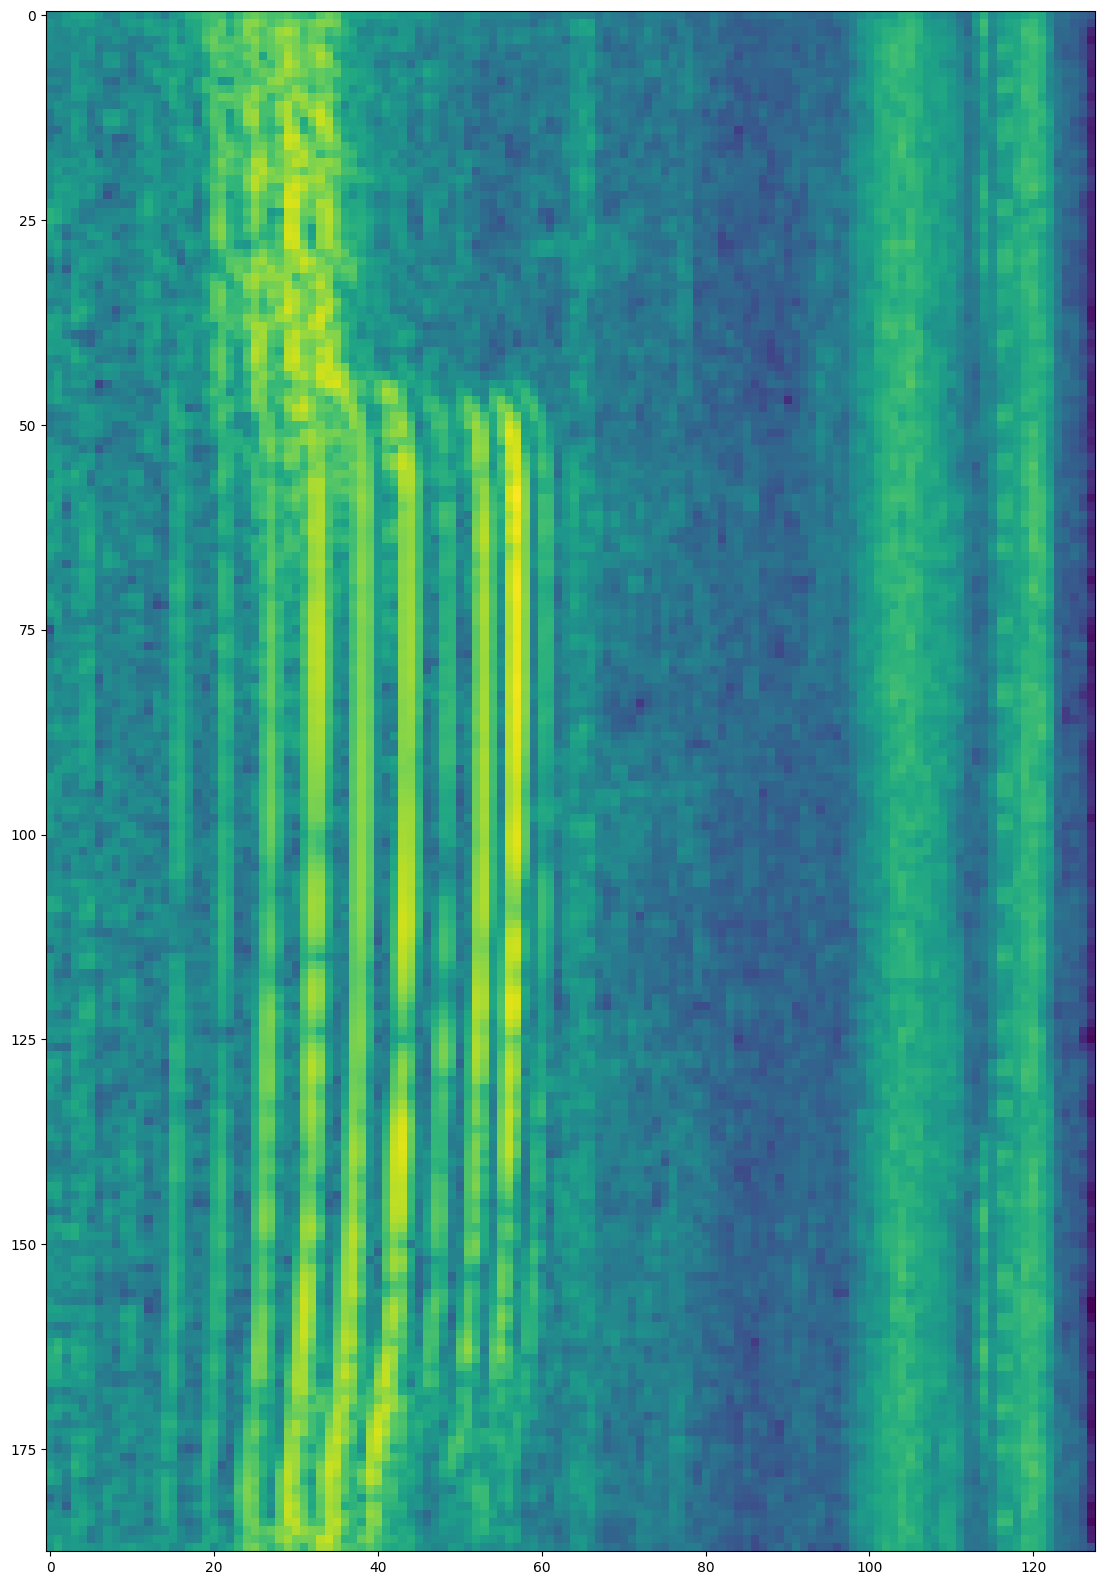

In [144]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [145]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

TypeError: in user code:

    File "C:\Users\AISHWARYA\AppData\Local\Temp\ipykernel_16656\971165098.py", line 3, in preprocess  *
        wav, sample_rate = librosa.load(file_path, sr=target_sample_rate)
    File "c:\Users\AISHWARYA\Desktop\Audio-Classifier\.conda\Lib\site-packages\librosa\core\audio.py", line 176, in load  *
        y, sr_native = __soundfile_load(path, offset, duration, dtype)
    File "c:\Users\AISHWARYA\Desktop\Audio-Classifier\.conda\Lib\site-packages\librosa\core\audio.py", line 209, in __soundfile_load  *
        context = sf.SoundFile(path)
    File "c:\Users\AISHWARYA\Desktop\Audio-Classifier\.conda\Lib\site-packages\soundfile.py", line 658, in __init__  **
        self._file = self._open(file, mode_int, closefd)
    File "c:\Users\AISHWARYA\Desktop\Audio-Classifier\.conda\Lib\site-packages\soundfile.py", line 1212, in _open
        raise TypeError("Invalid file: {0!r}".format(self.name))

    TypeError: Invalid file: <tf.Tensor 'args_0:0' shape=() dtype=string>


In [ ]:
train = data.take(36)
test = data.skip(36).take(15)

In [ ]:
samples, labels = train.as_numpy_iterator().next()


In [ ]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(1491, 257,1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])


In [ ]:
model.summary()


In [ ]:
hist = model.fit(train, epochs=4, validation_data=test)


In [ ]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

In [ ]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

In [ ]:
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

In [ ]:
X_test, y_test = test.as_numpy_iterator().next()


In [ ]:
yhat = model.predict(X_test)


In [ ]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]


In [ ]:
def load_mp3_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    res = tfio.audio.AudioIOTensor(filename)
    # Convert to tensor and combine channels 
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2 
    # Extract sample rate and cast
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Resample to 16 kHz
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    return wav

In [ ]:
mp3 = os.path.join('data', 'Forest Recordings', 'recording_00.mp3')


In [ ]:
wav = load_mp3_16k_mono(mp3)


In [ ]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)


In [ ]:
samples, index = audio_slices.as_numpy_iterator().next()


In [ ]:
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

In [ ]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=16000, sequence_stride=16000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [ ]:
yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

In [ ]:
yhat = [key for key, group in groupby(yhat)]
calls = tf.math.reduce_sum(yhat).numpy()

In [ ]:
results = {}
for file in os.listdir(os.path.join('data', 'Forest Recordings')):
    FILEPATH = os.path.join('data','Forest Recordings', file)
    
    wav = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)
    
    yhat = model.predict(audio_slices)
    
    results[file] = yhat

results

In [ ]:
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.99 else 0 for prediction in logits]
class_preds

In [ ]:
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
postprocessed

In [ ]:
with open('results.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'capuchin_calls'])
    for key, value in postprocessed.items():
        writer.writerow([key, value])